In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import os

import optuna
import wandb 
import gc

2025-11-29 19:53:06.785824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-29 19:53:06.785851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-29 19:53:06.786684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-29 19:53:06.791247: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    print("TensorFlow is using the GPU \n", gpus)
else:
    print("No GPU detected.")
    
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow is using the GPU 
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-11-29 19:53:14.015624: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-29 19:53:14.022718: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-29 19:53:14.023605: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
gc.collect()
tf.keras.backend.clear_session()

In [4]:
from wandb.integration.keras import WandbMetricsLogger

wandb.require("core")
wandb.login()

wandb: WARNING `wandb.require('core')` is a no-op as it is now the default behavior.
wandb: Currently logged in as: emmdaz (emmdaz-zzz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, (160, 160))
    return img, label

def make_dataset(paths, labels, batch_size = 32, shuffle = False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [6]:
# Se cargan los datos
# Se debe de realizar una transformación en los datos, haciendo que todas las identidades sean 0:

ds = pd.read_csv("/tf/Face-Recognition/CelebA/identity_CelebA.txt", sep = r"\s+", names=["image", "identity"])

ds["identity"] = 0
ds.head()

,image,identity
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [7]:
# img_dir = "/tf/Face-Recognition/CelebA/img_align_celeba"

# ds["image_path"] = ds["image"].apply(lambda x: os.path.join(img_dir, x))
ds = ds.sample(200, random_state = 4).reset_index(drop = True)
ds.head()

,image,identity
0,050310.jpg,0
1,175279.jpg,0
2,011029.jpg,0
3,078879.jpg,0
4,012327.jpg,0


In [8]:
image = np.array([])
identity = np.zeros(136)

for i in range(136):
    image = np.append(image, f"me{i+1}.jpg")
    identity[i] = 1

identity = identity.astype(int)

# print(image)
# print(identity)

df = pd.DataFrame({
    "image": image,
    "identity": identity,
})

# me_dir = "/tf/Face-Recognition/CelebA/Me"
# df["image_path"] = df["image"].apply(lambda x: os.path.join(me_dir, x))

# df.head()
df

,image,identity
0,me1.jpg,1
1,me2.jpg,1
2,me3.jpg,1
3,me4.jpg,1
4,me5.jpg,1
...,...,...
131,me132.jpg,1
132,me133.jpg,1
133,me134.jpg,1
134,me135.jpg,1


In [9]:
ds = pd.concat([ds, df], axis = 0)
ds = ds.sample(frac = 1, random_state = 5).reset_index(drop = True)
ds

,image,identity
0,015655.jpg,0
1,161731.jpg,0
2,me120.jpg,1
3,me103.jpg,1
4,152008.jpg,0
...,...,...
331,138118.jpg,0
332,010888.jpg,0
333,068816.jpg,0
334,054879.jpg,0


In [10]:
df_train, df_temp = train_test_split(
    ds, test_size = 0.4, stratify = ds["identity"], random_state = 5)

df_val, df_test = train_test_split(
    df_temp, test_size = 0.5, stratify = df_temp["identity"], random_state = 5)

In [11]:
print(df_train["identity"].value_counts())
print(df_val["identity"].value_counts())
print(df_test["identity"].value_counts())

identity
0    120
1     81
Name: count, dtype: int64
identity
0    40
1    27
Name: count, dtype: int64
identity
0    40
1    28
Name: count, dtype: int64


In [12]:
def reset_dataset_dir(base="data"):
    if os.path.exists(base):
        shutil.rmtree(base)
    os.makedirs(os.path.join(base, "train/me"))
    os.makedirs(os.path.join(base, "train/others"))
    os.makedirs(os.path.join(base, "val/me"))
    os.makedirs(os.path.join(base, "val/others"))
    os.makedirs(os.path.join(base, "test/me"))
    os.makedirs(os.path.join(base, "test/others"))

In [13]:
import shutil

base = "faces"

for split in ["train", "val", "test"]:
    os.makedirs(f"{base}/{split}/me", exist_ok = True)
    os.makedirs(f"{base}/{split}/others", exist_ok = True)

In [14]:
def copy_files(df, split):
    for idx, row in df.iterrows():
        if row["identity"] == 1:
            src = os.path.join("/tf/Face-Recognition/CelebA/Me", row["image"])
            dst = f"{base}/{split}/me/{row['image']}"
        else:
            src = os.path.join("/tf/Face-Recognition/CelebA/img_align_celeba", row["image"])
            dst = f"{base}/{split}/others/{row['image']}"
        
        shutil.copy(src, dst)

In [15]:
reset_dataset_dir()

copy_files(df_train, "train")
copy_files(df_val, "val")
copy_files(df_test, "test")

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True)

test_val_datagen = ImageDataGenerator()

In [17]:
train = train_datagen.flow_from_directory(
    f"{base}/train",
    target_size = (160,160),
    class_mode = "binary",
    batch_size = 32,
    seed = 4,
    shuffle = True)

val = test_val_datagen.flow_from_directory(
    f"{base}/val",
    target_size = (160,160),
    class_mode = "binary",
    batch_size = 32,
    seed = 4,
    shuffle = False)

test = test_val_datagen.flow_from_directory(
    f"{base}/test",
    target_size = (160,160),
    class_mode = "binary",
    batch_size = 32,
    seed = 4,
    shuffle = False)

Found 201 images belonging to 2 classes.
Found 67 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [18]:
FeatureExtractor = tf.keras.models.load_model("/tf/Face-Recognition/Models/Conv2D-MobileNetV2-Based-Fine-Tunned.keras")
FeatureExtractor.trainable = False

FeatureExtractor_Output = FeatureExtractor.layers[-3].output
FeatureExtractor_Model = tf.keras.Model(FeatureExtractor.input, FeatureExtractor_Output)

for layer in FeatureExtractor_Model.layers:
    layer.trainable = False

2025-11-29 19:53:15.085358: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-29 19:53:15.086273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-29 19:53:15.086998: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [19]:
lr = 1e-4
optimizer = tf.keras.optimizers.RMSprop(learning_rate = lr) 

In [21]:
inputs = tf.keras.Input(shape=(160,160,3))
# x = FeatureExtractor_Model(inputs)
x = tf.keras.layers.Dense(256, activation="leaky_relu")(FeatureExtractor_Model.output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation = "leaky_relu")(x)
x = tf.keras.layers.Dropout(0.15)(x)
x = tf.keras.layers.Dense(256, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)

outputs = tf.keras.layers.Dense(1, activation = "sigmoid", dtype = "float32",name = "classifier_head")(x)

model = tf.keras.Model(inputs = FeatureExtractor_Model.input, outputs = outputs)

model.compile(loss = "binary_crossentropy",
              optimizer = optimizer,
              metrics = ["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                   

In [22]:
early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, restore_best_weights = True)
lr_reduction = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 7)

In [23]:
wandb.init(
        project = "Face-Recognition-Conv2D-Trials-Exp-Series1.0",
        name = "Trial_1_FullSet",
        reinit = True,
        config = {
            "activation": "leaky_relu, relu",
            "n_layers": 3,
            "learning_rate": lr,
            "optimizer": "RMSProp"
        }
    )

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [24]:
history = model.fit(
    train, 
    validation_data = val,
    epochs = 200,
    verbose = 1, 
    callbacks = [WandbMetricsLogger(log_freq = 5), early_stopping, lr_reduction]
        )

Epoch 1/200


2025-11-29 19:53:42.349196: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-11-29 19:53:44.508668: I external/local_xla/xla/service/service.cc:168] XLA service 0x726da8ab5080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-29 19:53:44.508690: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-11-29 19:53:44.513160: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764446024.545964   99803 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 [==============================] - 8s 573ms/step - loss: 0.6853 - accuracy: 0.5423 - val_loss: 0.6439 - val_accuracy: 0.5970 - lr: 1.0000e-04
Epoch 2/200
7/7 [==============================] - 2s 258ms/step - loss: 0.6559 - accuracy: 0.5970 - val_loss: 0.6215 - val_accuracy: 0.6119 - lr: 1.0000e-04
Epoch 3/200
7/7 [==============================] - 2s 218ms/step - loss: 0.6310 - accuracy: 0.6169 - val_loss: 0.6018 - val_accuracy: 0.6119 - lr: 1.0000e-04
Epoch 4/200
7/7 [==============================] - 2s 234ms/step - loss: 0.6108 - accuracy: 0.6418 - val_loss: 0.5831 - val_accuracy: 0.7015 - lr: 1.0000e-04
Epoch 5/200
7/7 [==============================] - 2s 219ms/step - loss: 0.5884 - accuracy: 0.6567 - val_loss: 0.5633 - val_accuracy: 0.7164 - lr: 1.0000e-04
Epoch 6/200
7/7 [==============================] - 2s 266ms/step - loss: 0.5852 - accuracy: 0.6617 - val_loss: 0.5466 - val_accuracy: 0.7612 - lr: 1.0000e-04
Epoch 7/200
7/7 [==============================] - 2s 232ms/step

In [25]:
model.save("Face-Recognition-Conv2D.keras")

In [26]:
tf.keras.backend.clear_session()
wandb.finish()
gc.collect()

batch/accuracy,▁▃▅▅▅▅▅▅▆▅▅▅▅▆█▆▆▆▇▆▇█▇▇▇▆▇▇▆▆▇▇█▇▇▆▇▇▇▇
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▆▆▅▅▅▅▅▅▅▅▁▄▄▄▃▄▃▂▃▄▂▂▃▂▂▃▂▃▂▂▂▃▂▂▁▁
epoch/accuracy,▁▂▃▃▃▄▅▅▅▆▇▇▆▆▆▇█▇▇▇█
epoch/epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁
epoch/val_accuracy,▁▁▁▄▄▅▅▅▆█████▇█▇▇▇▇▇
epoch/val_loss,█▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
batch/accuracy,0.85799


623

### Fine-Tunning

In [27]:
for layer in FeatureExtractor_Model.layers[:-5]:
    layer.trainable = False

for layer in FeatureExtractor_Model.layers[-5:]:
    layer.trainable = True

In [28]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-6)

model.compile(loss = "binary_crossentropy",
              optimizer = optimizer,
              metrics = ["accuracy"])

In [29]:
wandb.init(
        project = "Conv2D-MobileNetV2-Based-Trials-Exp-Series1.0",
        name = "FineTunning_1_FullSet",
        reinit = True,
        config = {
            "activation": "leaky_relu, relu",
            "n_layers": 3,
            "learning_rate": lr,
            "optimizer": "RMSProp"
        }
    )

history = model.fit(
    train, 
    validation_data = val,
    epochs = 10,
    verbose = 1)


Epoch 1/10
7/7 [==============================] - 4s 305ms/step - loss: 0.4933 - accuracy: 0.7811 - val_loss: 0.4664 - val_accuracy: 0.8806
Epoch 2/10
7/7 [==============================] - 2s 228ms/step - loss: 0.4740 - accuracy: 0.7960 - val_loss: 0.4661 - val_accuracy: 0.8806
Epoch 3/10
7/7 [==============================] - 2s 223ms/step - loss: 0.4791 - accuracy: 0.8209 - val_loss: 0.4659 - val_accuracy: 0.8806
Epoch 4/10
7/7 [==============================] - 2s 227ms/step - loss: 0.4916 - accuracy: 0.7612 - val_loss: 0.4657 - val_accuracy: 0.8806
Epoch 5/10
7/7 [==============================] - 2s 221ms/step - loss: 0.5000 - accuracy: 0.7910 - val_loss: 0.4655 - val_accuracy: 0.8806
Epoch 6/10
7/7 [==============================] - 2s 226ms/step - loss: 0.4857 - accuracy: 0.7960 - val_loss: 0.4652 - val_accuracy: 0.8806
Epoch 7/10
7/7 [==============================] - 2s 225ms/step - loss: 0.4880 - accuracy: 0.8109 - val_loss: 0.4650 - val_accuracy: 0.8806
Epoch 8/10
7/7 [====

In [31]:
model.save("Face-Recognition-Conv2D-Fine-Tunned.keras") 

In [32]:
tf.keras.backend.clear_session()
wandb.finish()
gc.collect()

637

In [33]:
model_ev = keras.models.load_model("Face-Recognition-Conv2D-Fine-Tunned.keras")

loss, accuracy = model_ev.evaluate(test, verbose = 1)

print(f"Test Loss: {loss:}")
print(f"Test Accuracy: {accuracy:}")

3/3 [==============================] - 2s 481ms/step - loss: 0.4688 - accuracy: 0.8529
Test Loss: 0.4687805473804474
Test Accuracy: 0.8529411554336548


3/3 [==============================] - 0s 32ms/step


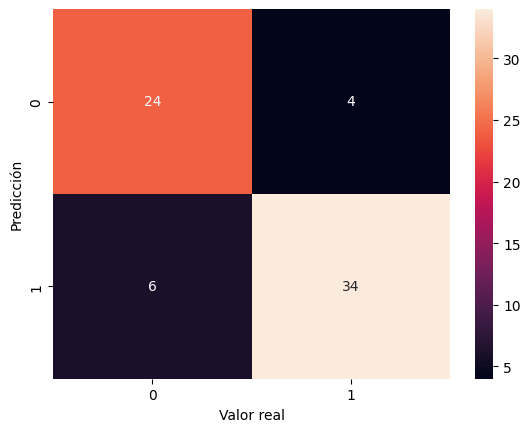

In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

pred_probs = model.predict(test)

y_pred = (pred_probs > 0.5).astype("int32")
y_pred = y_pred.reshape(-1)

y_true = test.classes

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot = True, fmt = "d", cmap = "rocket")

plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.show()